# Watershed segmentation
* Qualquer imagem em tons de cinza pode ser vista como uma superfície topográfica onde a alta intensidade denota picos e colinas, enquanto a baixa intensidade denota vales;
*  O algoritmo preenche todos os vales isolados (mínimos locais) com água de cores diferentes (rótulos);
* Conforme a água sobe, dependendo dos picos (gradientes) próximos, água de diferentes vales, obviamente com cores diferentes, começará a se fundir; 
* Para evitar isso, constrói-se barreiras nos locais onde a água se funde. Continua-se o trabalho de encher a água e construir barreiras até que todos os picos estejam debaixo d'água. Então, as barreiras construídas fornecem o resultado da segmentação. 


In [23]:
import numpy as np
import cv2 
from matplotlib import pyplot as plt

## 1) Binarização da imagem
* Encontrando uma estimativa aproximada das moedas, para isso, pode-se usar a binarização de Otsu.

In [2]:
img = cv2.imread('coins_02.png')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

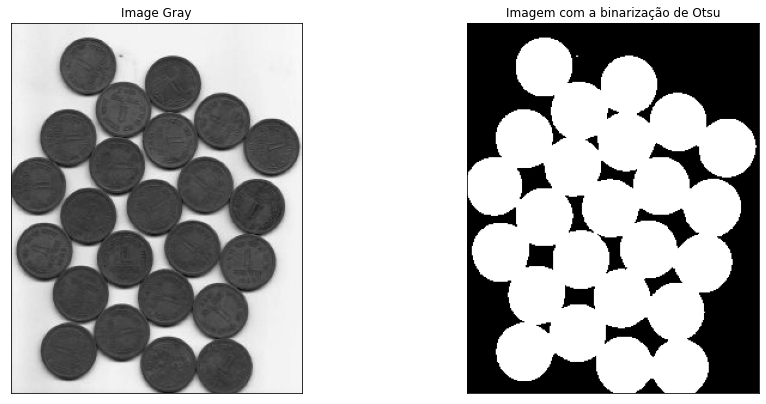

In [24]:
plt.figure(figsize=(15, 15))
plt.subplot(2,2,1),plt.imshow(gray,cmap = 'gray')
plt.title('Image Gray'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(thresh,cmap = 'gray')
plt.title('Imagem com a binarização de Otsu'), plt.xticks([]), plt.yticks([])
plt.show()

## Removendo ruído 

* Removendo todos os pequenos ruídos brancos da imagem, para isso é usado a abertura morfológica;
* Para remover quaisquer pequenos orifícios no objeto, é usado o fechamento morfológico; 
* Portanto, agora sabe-se com certeza que a região próxima ao centro dos objetos é o primeiro plano e a região muito distante do objeto é o plano de fundo;
* A única região que não tem-se certeza é a região limite das moedas.

In [3]:
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)

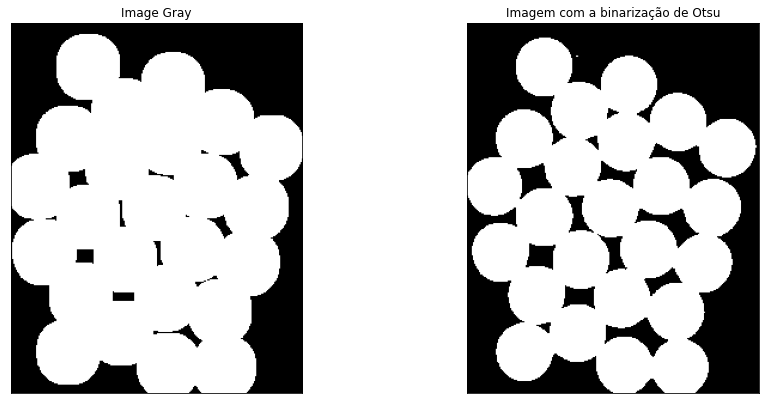

In [25]:
plt.figure(figsize=(15, 15))
plt.subplot(2,2,1),plt.imshow(sure_bg,cmap = 'gray')
plt.title('Image Gray'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(thresh,cmap = 'gray')
plt.title('Imagem com a binarização de Otsu'), plt.xticks([]), plt.yticks([])
plt.show()

## Extraindo a área que realmente são moedas

* Portanto, precisa-se extrair a área da qual tem-se certeza que são moedas;
* Uma vez que os objetos estão se tocando, uma boa opção é encontrar a transformação de distância e aplicar um limite adequado; 
* Em seguida, precisa-se encontrar a área que certamente não são moedas. Para isso, o resultado é dilatado. A dilatação aumenta o limite do objeto para o fundo. Dessa forma, tem-se certeza de que qualquer região no fundo do resultado é realmente um fundo, uma vez que a região limite é removida;
* As regiões restantes são aquelas que são desconhecidas, sejam moedas ou fundo; 
* Essas áreas estão normalmente em torno dos limites das moedas onde o primeiro plano e o plano de fundo se encontram (ou até mesmo duas moedas diferentes se encontram). 
* Isso é chamado de fronteira, e pode ser obtida subtraindo a área da região desconhecida(*sure_fg*) da área de fundo(*sure_bg*).

In [4]:
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

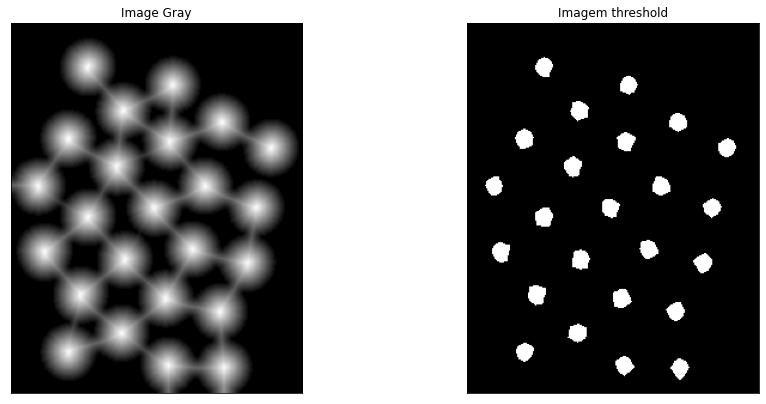

In [28]:
plt.figure(figsize=(15, 15))

plt.subplot(2,2,1),plt.imshow(dist_transform,cmap = 'gray')
plt.title('Image Gray'), plt.xticks([]), plt.yticks([])

plt.subplot(2,2,2),plt.imshow(sure_fg,cmap = 'gray')
plt.title('Imagem threshold'), plt.xticks([]), plt.yticks([])

plt.show()

## Criando os marcadores

* Após descobrir com certeza quais são as regiões das moedas, quais são os fundos e tudo mais; 
* Proximo passo é portanto, criar os marcadores (é um array do mesmo tamanho da imagem original, mas com o tipo de dados int32) e rotular as regiões dentro deles. 
* As regiões conhecidas com certeza (seja primeiro ou segundo plano) são rotuladas com quaisquer inteiros positivos, mas inteiros diferentes, e a área que não se sabe com certeza são deixadas como zero. 
* Para isso, é usado *cv.connectedComponents()*. Esse método rotula o fundo da imagem com 0 e, em seguida, outros objetos são rotulados com inteiros começando em 1.
* Mas sabe-se que se o fundo estiver marcado com 0, o *watershed* considerará como área desconhecida. Então, queremos marcá-lo com um número inteiro diferente. Em vez disso, marcaremos a região desconhecida com 0.
* O resultado mostrado no mapa de cores JET, a região azul escura mostra região desconhecida. Claro que as moedas são coloridas com valores diferentes. As áreas restantes com fundo seguro são mostradas em azul mais claro em comparação com a região desconhecida.

In [6]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
# Adicione um a todos os rótulos para que o fundo certo não seja 0, mas 1
markers = markers+1
# Marcando a região desconhecida com 0
markers[unknown==255] = 0

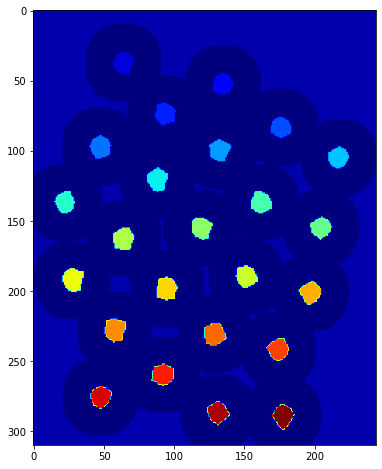

In [38]:
plt.figure(figsize=(8, 8))
plt.imshow(markers, cmap='jet')
plt.show()

## Aplicando o *watershed*
* Agora que os marcadores estão prontos, é hora da etapa final, aplicar o *watershed*. Em seguida, a imagem do marcador será modificada. A região limite será marcada com -1.

In [39]:
markers_wate_01 = cv2.watershed(img,markers)
img_c2 = img.copy() 
img_c2[markers_wate_01 == -1] = [255,0,0]

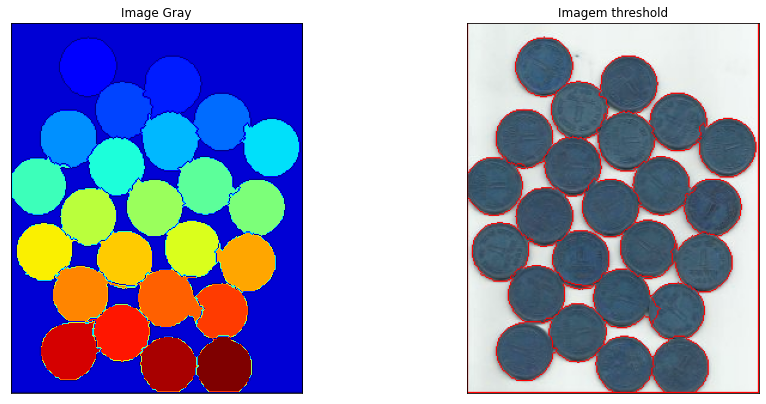

In [40]:
plt.figure(figsize=(15, 15))
plt.subplot(2,2,1),plt.imshow(markers_wate_01, cmap='jet')
plt.title('Image Gray'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(img_c2)
plt.title('Imagem threshold'), plt.xticks([]), plt.yticks([])
plt.show()